In [27]:
import pandas as pd
from dbrepo.RestClient import RestClient
import os
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from dotenv import load_dotenv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [28]:

# load secrets setup DBRepo client and load datasets
load_dotenv("./secrets.env")

client = RestClient(endpoint=os.environ["DB_REPO_HOST"], username=os.environ["DB_REPO_USER"], password=os.environ["DB_REPO_PASSWORD"])
training_df: pd.DataFrame = client.get_identifier_data(identifier_id="7f9bf749-903d-4722-8dbf-11e66e6af731")
validation_df: pd.DataFrame = client.get_identifier_data(identifier_id="c4c52669-3eee-41dd-bfc8-71bb290c41aa")
test_df: pd.DataFrame = client.get_identifier_data(identifier_id="42629aa2-c5a0-45d8-94ee-229124323a97")

In [3]:
def feature_encodings(df: pd.DataFrame, categorical_col_names: list[str]):
    """
    Transforms categorical variables to one hot encodings and converts numberic objects to numbers
    :param categorical_col_names: names of categorical variables
    :param df: The input dataframe
    :return: The input dataframe with categorical columns transformed to one hot encodings
    """

    df_with_one_hots =  pd.get_dummies(df,columns=categorical_col_names)
    df_with_one_hots = df_with_one_hots.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    return df_with_one_hots



def get_dataset_features_and_targets(input_df:pd.DataFrame):
    """
    Takes an input dataframe drops unnecessary columns,
    transforms categorical variables to one hot encodings
     and constructs a matrix optimized for xgboost.
    :param input_df: The input dataframe
    :return: xgb.DMatrix containing features and targets,
    """

    features = input_df.drop(columns=["index_col", "date_and_hour", "regression_split","rented_bike_count"])
    categorical_cols = ['seasons', 'holiday', 'functioning_day']
    features = feature_encodings(features, categorical_col_names=categorical_cols)
    target = input_df['rented_bike_count']

    feature_and_target_matrix = xgb.DMatrix(features, label=target)

    return feature_and_target_matrix

In [4]:
# prepare datasets
dtrain = get_dataset_features_and_targets(training_df)
dval = get_dataset_features_and_targets(validation_df)
dtest = get_dataset_features_and_targets(test_df)

In [5]:
# Define model parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# Train the model with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dval, 'validation')],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	validation-rmse:605.63961
[1]	validation-rmse:571.74025
[2]	validation-rmse:544.09193
[3]	validation-rmse:518.30209
[4]	validation-rmse:496.45868
[5]	validation-rmse:476.17257
[6]	validation-rmse:460.19654
[7]	validation-rmse:445.45019
[8]	validation-rmse:433.46077
[9]	validation-rmse:422.25720
[10]	validation-rmse:412.94792
[11]	validation-rmse:405.09859
[12]	validation-rmse:397.37852
[13]	validation-rmse:390.92557
[14]	validation-rmse:386.16901
[15]	validation-rmse:381.69180
[16]	validation-rmse:378.40527
[17]	validation-rmse:374.49086
[18]	validation-rmse:371.64308
[19]	validation-rmse:369.12112
[20]	validation-rmse:366.54513
[21]	validation-rmse:364.46800
[22]	validation-rmse:362.34260
[23]	validation-rmse:360.41160
[24]	validation-rmse:358.16739
[25]	validation-rmse:357.11258
[26]	validation-rmse:355.56577
[27]	validation-rmse:354.44795
[28]	validation-rmse:353.50488
[29]	validation-rmse:352.66619
[30]	validation-rmse:352.32410
[31]	validation-rmse:351.89675
[32]	validation-rm

In [6]:

def evaluate_model(y_true, y_pred):

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics = {
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }

    return metrics


    
y_pred = model.predict(dtest)

print(evaluate_model(dtest.get_label(), y_pred))

{'RMSE': np.float64(342.9240531808756), 'MAE': 233.9310760498047, 'R²': 0.7112938165664673}


In [7]:
y_true_col = "y_true"
y_pred_col = "y_preds"
datetime_col = "date_times"
resample_interval = "5h"
visual_df = pd.DataFrame({y_true_col:dtest.get_label(),y_pred_col:y_pred,datetime_col:pd.to_datetime(test_df.date_and_hour)})
visual_df = visual_df.sort_values(datetime_col,ascending=True)

visual_df = visual_df.set_index(datetime_col)
visual_df = visual_df[[y_true_col, y_pred_col]].resample(resample_interval).mean().reset_index()


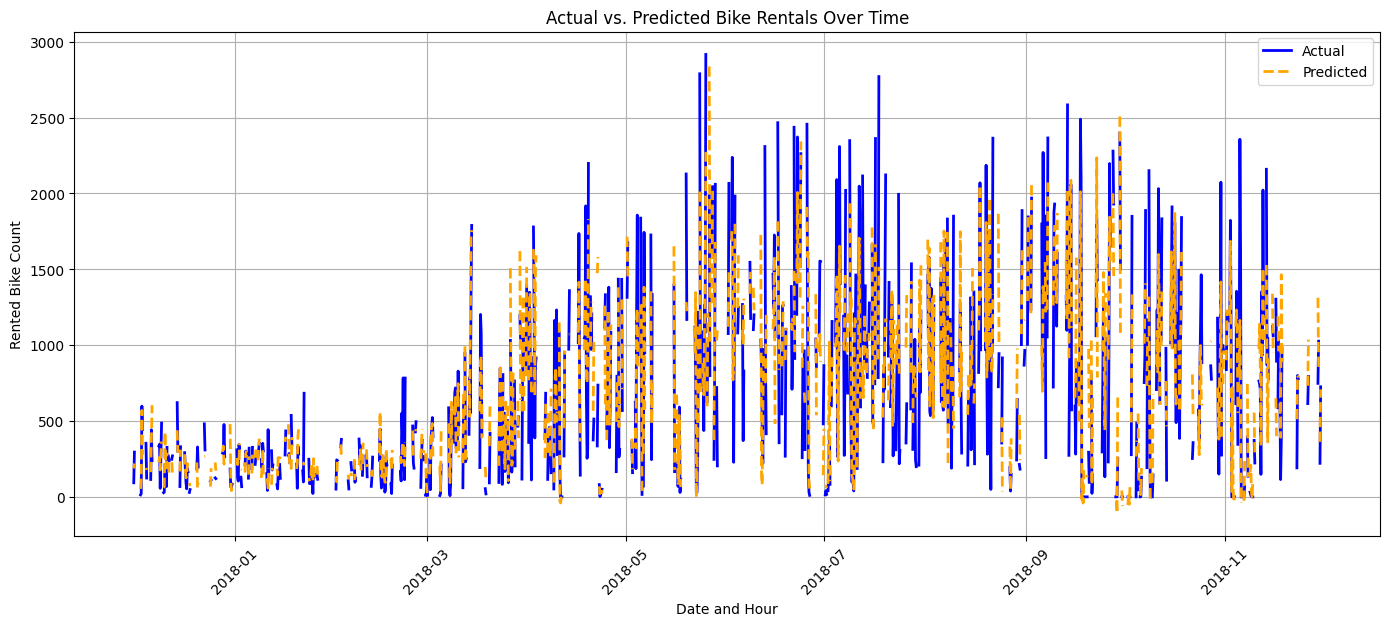

In [29]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 6))
plt.plot(visual_df[datetime_col], visual_df[y_true_col], label='Actual', color='blue', linewidth=2)
plt.plot(visual_df[datetime_col], visual_df[y_pred_col], label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Date and Hour')
plt.ylabel('Rented Bike Count')
plt.title('Actual vs. Predicted Bike Rentals Over Time')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)
#plt.show()
plt.savefig("./test.png")

In [44]:
import requests
from datetime import date
from dotenv import load_dotenv

load_dotenv("./secrets.env")
ACCESS_TOKEN = "OTa9TRhTAO8xDAaDpOR1dUwpuX7Oq3hlBQigrpbCfHmmNUwhHzEOuhwkL7Vw"#os.environ["TUWRD_ACCESS_TOKEN"]

def create_record(
    access_token: str,

    title: str,
    given_name: str,
    family_name: str,
    resource_type: str = "software",
    publisher: str = "TU Wien",
    publication_date: str = None):
    """
    Creates a record in TUWRD

    Parameters:
        access_token (str): TUWRD access token.
        file_path (str): Path to the file to upload (e.g., "model.pkl"). Can also be temp file.
        title (str): Title for the record (e.g., "Trained xgboost Model").
        given_name (str): Your first name.
        family_name (str): Your last name.
        resource_type (str): 'software' or 'dataset' or others. Default is 'software'.
        publisher (str): Default "TU Wien".
        publication_date (str): ISO format date, e.g., "2025-04-27". Defaults to today.
    """

    url = "https://test.researchdata.tuwien.at/api/records"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    data = {
        "metadata": {
            "creators": [
                {
                    "person_or_org": {
                        "family_name": given_name,
                        "given_name": family_name,
                        "type": "personal",
                    }
                }
            ],
            "publication_date": publication_date,
            "publisher": publisher,
            "resource_type": {"id": resource_type},
            "title": title,
        },
        "files": {"enabled": True},
    }

    response = requests.post(url, json=data, headers=headers)
    print(response.json())

    if response.status_code != 201:
        print("Error creating draft record:", response.text)
        return

    record = response.json()
    record_id = record["id"]
    print(f"Draft record created! Record ID: {record_id}")
    return record_id
    
def upload_to_tuwrd(
    record_id: str,
    access_token: str,
    file_path: str,
    file_name: str,
    title: str,
    given_name: str,
    family_name: str,
    resource_type: str = "software",
    publisher: str = "TU Wien",
    publication_date: str = None
):
    """
    Uploads a file to TUWRD, attaches metadata, assigns DOI.

    Parameters:
        access_token (str): TUWRD access token.
        file_path (str): Path to the file to upload (e.g., "model.pkl"). Can also be temp file.
        title (str): Title for the record (e.g., "Trained xgboost Model").
        given_name (str): Your first name.
        family_name (str): Your last name.
        resource_type (str): 'software' or 'dataset' or others. Default is 'software'.
        publisher (str): Default "TU Wien".
        publication_date (str): ISO format date, e.g., "2025-04-27". Defaults to today.
    """




    url = f"https://test.researchdata.tuwien.at/api/records/{record_id}/draft/files"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    data = [
        {
            "key": file_name
        }
    ]

    response = requests.post(url, json=data, headers=headers)
    print(response.json())


    url = f"https://test.researchdata.tuwien.at/api/records/{record_id}/draft/files/{file_name}/content"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/octet-stream"
    }

    with open(file_path, "rb") as file_data:
        response = requests.put(url, headers=headers, data=file_data)


    print("Files committed successfully.")


    url =f"https://test.researchdata.tuwien.at/api/records/{record_id}/draft/files/{file_name}/commit"
    headers = {
        "Authorization": f"Bearer {access_token}",
    }

    response = requests.post(url, headers=headers)
 
    url = "https://test.researchdata.tuwien.at/api/curations/"
    headers = {
        "Authorization": f"Bearer {access_token}",
    }
    data = {
      "topic":{
          "record": record_id
      }
    }
    
    response = requests.post(url, json=data, headers=headers)
    print(response.json())
    
    return record_id
record_id = create_record(access_token=ACCESS_TOKEN,
                title="Seoul bike demand prediction artifacts",
                given_name="Lukas",
                family_name="Kobler",
                resource_type="dataset",
                publication_date=str(date.today()))

In [46]:
import tempfile
with tempfile.NamedTemporaryFile(suffix=".bin") as tmp:
    model.save_model(tmp.name)  # Save to tmp file
    upload_to_tuwrd(
                    record_id=record_id,
                    access_token=ACCESS_TOKEN,
                    file_path=tmp.name,
                    file_name="xgboost_model.bin",
                    title="Xgboost Regression model",
                    given_name="Lukas",
                    family_name="Kobler",
                    resource_type="software",
                    publication_date=str(date.today()))





    
    

/var/folders/7t/07q7cd8n7vqdwhdrgvhj5n7m0000gn/T/ipykernel_26707/1123499877.py:3: UserWarning: [15:20:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  model.save_model(tmp.name)  # Save to tmp file


{'enabled': True, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files'}, 'entries': [{'key': 'xgboost_model.bin', 'created': '2025-04-28T13:20:20.796306+00:00', 'updated': '2025-04-28T13:20:20.797582+00:00', 'status': 'pending', 'metadata': None, 'access': {'hidden': False}, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin', 'content': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/content', 'commit': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/commit'}}], 'default_preview': None, 'order': []}
Files committed successfully.
{'id': '07906079-b2d4-4e24-a4b3-fa9050505428', 'created': '2025-04-28T13:20:21.193551+00:00', 'updated': '2025-04-28T13:20:21.198424+00:00', 'links': {'actions': {'cancel': 'https://test.researchdata.tuwien.at/api/requests/07906079-b2d4-4e24-a4b3-fa9050505428/actions/cancel'}, 'se

In [48]:
upload_to_tuwrd(
                record_id=record_id,
                access_token=ACCESS_TOKEN,
                file_path="visual.png",
                file_name="test_dataset_visual.png",
                title="Test set forecast",
                given_name="Lukas",
                family_name="Kobler",
                resource_type="software",
                publication_date=str(date.today()))

{'enabled': True, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files'}, 'entries': [{'key': 'xgboost_model.bin', 'storage_class': 'L', 'checksum': 'md5:3ffb4cd7d906a6880eb04891bfa36c8d', 'size': 537601, 'created': '2025-04-28T13:20:20.796306+00:00', 'updated': '2025-04-28T13:20:21.136589+00:00', 'status': 'completed', 'mimetype': 'application/octet-stream', 'version_id': '9cef7e7b-de6a-44dd-a176-4a82df125acb', 'file_id': 'fef23796-2497-43ad-b6b6-4c7382971d49', 'bucket_id': '533e038b-7808-45e8-9eb9-2e01471e4502', 'metadata': {}, 'access': {'hidden': False}, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin', 'content': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/content', 'commit': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/commit'}}, {'key': 'test_dataset_visual.png', 'created': '2025-04-28T13:2

'wvqpp-nhb32'

In [11]:
test_df_with_predictions =  test_df.copy()
test_df_with_predictions["predictions"] = y_pred


In [38]:
test_df_with_predictions.to_csv("./test_set_predictions.csv", index=False)

In [49]:
upload_to_tuwrd(
                record_id=record_id,
                access_token=ACCESS_TOKEN,
                file_path="test_set_predictions.csv",
                file_name="test_set_predictions.csv",
                title="Test set predictions",
                given_name="Lukas",
                family_name="Kobler",
                resource_type="software",
                publication_date=str(date.today()))

{'enabled': True, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files'}, 'entries': [{'key': 'xgboost_model.bin', 'storage_class': 'L', 'checksum': 'md5:3ffb4cd7d906a6880eb04891bfa36c8d', 'size': 537601, 'created': '2025-04-28T13:20:20.796306+00:00', 'updated': '2025-04-28T13:20:21.136589+00:00', 'status': 'completed', 'mimetype': 'application/octet-stream', 'version_id': '9cef7e7b-de6a-44dd-a176-4a82df125acb', 'file_id': 'fef23796-2497-43ad-b6b6-4c7382971d49', 'bucket_id': '533e038b-7808-45e8-9eb9-2e01471e4502', 'metadata': {}, 'access': {'hidden': False}, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin', 'content': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/content', 'commit': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/commit'}}, {'key': 'test_dataset_visual.png', 'storage_class': 'L', 'chec

'wvqpp-nhb32'

In [50]:
upload_to_tuwrd(
                record_id=record_id,
                access_token=ACCESS_TOKEN,
                file_path="codemeta.json",
                file_name="codemeta.json",
                title="Test set predictions",
                given_name="Lukas",
                family_name="Kobler",
                resource_type="software",
                publication_date=str(date.today()))

{'enabled': True, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files'}, 'entries': [{'key': 'xgboost_model.bin', 'storage_class': 'L', 'checksum': 'md5:3ffb4cd7d906a6880eb04891bfa36c8d', 'size': 537601, 'created': '2025-04-28T13:20:20.796306+00:00', 'updated': '2025-04-28T13:20:21.136589+00:00', 'status': 'completed', 'mimetype': 'application/octet-stream', 'version_id': '9cef7e7b-de6a-44dd-a176-4a82df125acb', 'file_id': 'fef23796-2497-43ad-b6b6-4c7382971d49', 'bucket_id': '533e038b-7808-45e8-9eb9-2e01471e4502', 'metadata': {}, 'access': {'hidden': False}, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin', 'content': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/content', 'commit': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/commit'}}, {'key': 'test_set_predictions.csv', 'storage_class': 'L', 'che

'wvqpp-nhb32'

In [51]:
upload_to_tuwrd(
                record_id=record_id,
                access_token=ACCESS_TOKEN,
                file_path="fair4ml_description.json",
                file_name="fair4ml_description.json",
                title="",
                given_name="Lukas",
                family_name="Kobler",
                resource_type="software",
                publication_date=str(date.today()))

{'enabled': True, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files'}, 'entries': [{'key': 'xgboost_model.bin', 'storage_class': 'L', 'checksum': 'md5:3ffb4cd7d906a6880eb04891bfa36c8d', 'size': 537601, 'created': '2025-04-28T13:20:20.796306+00:00', 'updated': '2025-04-28T13:20:21.136589+00:00', 'status': 'completed', 'mimetype': 'application/octet-stream', 'version_id': '9cef7e7b-de6a-44dd-a176-4a82df125acb', 'file_id': 'fef23796-2497-43ad-b6b6-4c7382971d49', 'bucket_id': '533e038b-7808-45e8-9eb9-2e01471e4502', 'metadata': {}, 'access': {'hidden': False}, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin', 'content': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/content', 'commit': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/xgboost_model.bin/commit'}}, {'key': 'test_set_predictions.csv', 'storage_class': 'L', 'che

'wvqpp-nhb32'

In [52]:
upload_to_tuwrd(
                record_id=record_id,
                access_token=ACCESS_TOKEN,
                file_path="xgboost_seoul_bike_demand.ipynb",
                file_name="xgboost_seoul_bike_demand.ipynb",
                title="",
                given_name="Lukas",
                family_name="Kobler",
                resource_type="software",
                publication_date=str(date.today()))

{'enabled': True, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files'}, 'entries': [{'key': 'fair4ml_description.json', 'storage_class': 'L', 'checksum': 'md5:c04c9c87e8dc4e55c30fa900c4271373', 'size': 1928, 'created': '2025-04-28T14:28:33.662202+00:00', 'updated': '2025-04-28T14:28:33.955232+00:00', 'status': 'completed', 'mimetype': 'application/json', 'version_id': '62216aa7-259d-447f-8a80-bf63145bde02', 'file_id': '2eb1d473-f06d-471b-a5a6-a9743cee7267', 'bucket_id': '533e038b-7808-45e8-9eb9-2e01471e4502', 'metadata': {}, 'access': {'hidden': False}, 'links': {'self': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/fair4ml_description.json', 'content': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/fair4ml_description.json/content', 'commit': 'https://test.researchdata.tuwien.at/api/records/wvqpp-nhb32/draft/files/fair4ml_description.json/commit'}}, {'key': 'xgboost_model.bin', 'storage_class'

'wvqpp-nhb32'